## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import tqdm
import json
import time
import sys

# Add the 'src' folder to the Python path
src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(src_dir)
# append the path of the directory containing the module you want to import
sys.path.append('master_thesis_dtu/src')

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../../')
from tqdm import tqdm
import numpy as np

from PIL import Image
sys.path.append('../')
from src.data.my_rpg_dataset import XRayDataSet_windows
from src.data.my_rpg_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.faster_rcnn import *
import torch
import matplotlib.pyplot as plt
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

from src.models.utils import *

#DERT model
from transformers import DetrForObjectDetection


Load model state


In [2]:
from transformers import DetrConfig, DetrForObjectDetection

config = DetrConfig.from_pretrained('facebook/detr-resnet-50',revision="no_timm",num_labels=2,id2label={0:"text",1:"fracture"},
                                                             ignore_mismatched_sizes=True) 
                                                             
detr_model = DetrForObjectDetection(config)
best_model = torch.load(f'../../models/Best_val_DETR_Model.pt',map_location=torch.device('cpu'))
detr_model.load_state_dict(best_model['model_state_dict'])
print(best_model['best_loss'])

0.8462895695899373


Load dataset

In [3]:
import sys
sys.path.append('../')
%cd ..
%cd ..
from src.data.my_rpg_dataset import CocoDetection
from src.data.my_rpg_dataset import collate_fn_COCO
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
test_dataset_detr = CocoDetection(path_folder="data", processor=processor,status='test')
test_dataloader_detr = DataLoader(test_dataset_detr, collate_fn=collate_fn_COCO, batch_size=1, shuffle=False,num_workers=0)

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\src
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [4]:
evaluator = CocoEvaluator(coco_gt=test_dataset_detr.coco, iou_types=["bbox"])

In [5]:
# train on the GPU or on the CPU, if a GPU is not available
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


#### Visualization

In [6]:


def plot_results(pil_img,img, scores_cnn, labels_cnn, boxes_cnn,scores_detr, labels_detr, boxes_detr,annotations,detr_model,image_id,confidence=0.7):
    fig = plt.figure(figsize=(15,10))

    fig.add_subplot(1, 4, 1)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()

    id2label = id2label={0:"text",1:"fracture"}

    for annotation in annotations:
        for label, box  in zip(torch.tensor([annotation['category_id']]).tolist(), torch.tensor([annotation['bbox']]).tolist()):
            if label == 0:
                c='white'
            else:
                c="red"
            x,y,w,h = tuple(box)
            ax.add_patch(plt.Rectangle((x,y),w,h,
                                    fill=False, color=c, linewidth=3))
            text = f'{detr_model.config.id2label[label]}'
            ax.text(x, y, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("Target Image and Boxes")
    ########################################################################################################
    fig.add_subplot(1, 4, 2)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    
    id2label = id2label={0:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax) in zip(scores_detr.tolist(), labels_detr.tolist(), boxes_detr.tolist()):
        if score >= confidence:
            if label == 0:
                c='white'
            else:
                c="red"
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{detr_model.config.id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title(f"DETR Model prediction {image_id}")

    ########################################################################################################
    fig.add_subplot(1, 4, 3)

    plt.imshow(np.asarray(pil_img),cmap='gray')
    ax = plt.gca()
    
    id2label = id2label={2:"text",1:"fracture"}
    for score, label, (xmin, ymin, xmax, ymax)  in zip(scores_cnn.tolist(), labels_cnn.tolist(), boxes_cnn.tolist()):
        if score >= confidence:
            if label == 2:
                c='white'
            else:
                c="red"
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            text = f'{id2label[label]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=12,
                    bbox=dict(facecolor='yellow', alpha=0.3))
    plt.axis('off')
    plt.title("CNN Model prediction")

    fig.add_subplot(1, 4, 4)

    plt.imshow(np.asarray(img),cmap='gray')
    plt.axis('off')
    plt.title("Target Image")


    plt.show()

take detr predictions

In [7]:
# Set the model to evaluation mode
detr_model.eval()
results_detr = []

# Iterate over all batches in the test loader
for idx, batch in enumerate(tqdm(test_dataloader_detr)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    target = labels[0]

    # forward pass
    with torch.no_grad():
      outputs = detr_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    # turn into a list of dictionaries (one item for each example in the batch)
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    #results = processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes,threshold=0.7)

    %cd notebooks
    # load image based on ID
    image_id = target['image_id'].item()
    image = test_dataset_detr.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join(image['file_name']))
    target_annotations = test_dataset_detr.coco.imgToAnns[image_id]
    %cd ..


    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.7)
    #Apply the nms function to the boxes 
    nms_results = []
    for result in postprocessed_outputs:
        # Get the boxes, scores, and labels from the current dictionary
        boxes = result['boxes']
        scores = result['scores']
        pred_labels = result['labels']
        
        # Apply NMS to the boxes
        keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
        
        # Create a new dictionary with the NMS-filtered boxes
        result_nms = {}
        result_nms['scores'] = scores[keep]
        result_nms['labels'] = pred_labels[keep]
        result_nms['boxes'] = boxes[keep]
        
        # Append the new dictionary to the `nms_results` list
        nms_results.append(result_nms)

    postprocessed_outputs = nms_results[0]

    results = postprocessed_outputs
    # Append the results to the list
    results_detr.append((image, results['scores'], results['labels'], results['boxes'], target_annotations, image_id))
    #plot_results(image, results['scores'], results['labels'], results['boxes'],target_annotations,detr_model,confidence=0.5)
    if idx == 30 : break

  0%|          | 0/3022 [00:00<?, ?it/s]c:\Users\spiro\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(
  0%|          | 1/3022 [00:04<3:49:14,  4.55s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 2/3022 [00:07<3:15:16,  3.88s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 3/3022 [00:11<3:10:15,  3.78s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 4/3022 [00:16<3:32:01,  4.22s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 5/3022 [00:20<3:34:59,  4.28s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 6/3022 [00:24<3:20:29,  3.99s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 7/3022 [00:27<3:15:09,  3.88s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 8/3022 [00:31<3:11:57,  3.82s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 9/3022 [00:35<3:04:21,  3.67s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 10/3022 [00:38<3:05:12,  3.69s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 11/3022 [00:42<3:02:18,  3.63s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 12/3022 [00:45<2:54:00,  3.47s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 13/3022 [00:50<3:15:59,  3.91s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 14/3022 [00:54<3:15:42,  3.90s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  0%|          | 15/3022 [00:58<3:24:38,  4.08s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 16/3022 [01:01<3:13:07,  3.85s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 17/3022 [01:05<3:06:06,  3.72s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 18/3022 [01:10<3:25:29,  4.10s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 19/3022 [01:19<4:36:43,  5.53s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 20/3022 [01:22<4:02:54,  4.85s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 21/3022 [01:33<5:38:19,  6.76s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 22/3022 [01:37<4:55:54,  5.92s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 23/3022 [01:42<4:45:33,  5.71s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 24/3022 [01:46<4:18:47,  5.18s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 25/3022 [01:50<4:02:39,  4.86s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 26/3022 [01:55<3:53:08,  4.67s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 27/3022 [01:58<3:37:59,  4.37s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 28/3022 [02:02<3:33:13,  4.27s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 29/3022 [02:07<3:39:34,  4.40s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 30/3022 [02:11<3:39:04,  4.39s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


  1%|          | 30/3022 [02:15<3:44:53,  4.51s/it]

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks
c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


take cnn perds


In [8]:
print(os.getcwd())  

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu


In [9]:
%cd notebooks

c:\Users\spiro\OneDrive\Υπολογιστής\Thesis\Project\master_thesis_dtu\notebooks


In [10]:
#load test data
test_dataset = XRayDataSet_windows(pathlib.Path('../literature/Other/supervisely/wrist/test_pickles_new'))
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0,collate_fn=collate_fn)

In [11]:
#load the model state

model = get_model_instance_segmentation(3)
best_model = torch.load(f'../models/Best_val_CNN_Model.pt',map_location=torch.device('cpu'))
model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [12]:
# Set the model to evaluation mode
model.eval()

results_cnn = []
confidence = 0.0

result_nms = []
for batch_idx, (images, targets) in enumerate(tqdm(test_dataloader)):
    
    # Get the predictions for the batch of images
    predictions = model(images)
  
    # Get the image, predicted scores, labels and boxes for the current image
    img = images[0].cpu().permute(1, 2, 0)
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    boxes = predictions[0]['boxes']

    # Apply NMS to the boxes
    keep = torchvision.ops.nms(boxes, scores, iou_threshold=0.5)
        
    # Create a new dictionary with the NMS-filtered boxes
    result_nms = {}
    result_nms['scores'] = scores[keep]
    result_nms['labels'] = labels[keep]
    result_nms['boxes'] = boxes[keep]

    # Append the results for the current image to the list
    #results_cnn.append((img,scores, labels,boxes))

    results_cnn.append((img,result_nms['scores'], result_nms['labels'], result_nms['boxes']))

    if batch_idx == 30 : break

  1%|          | 30/3023 [03:13<5:22:24,  6.46s/it]


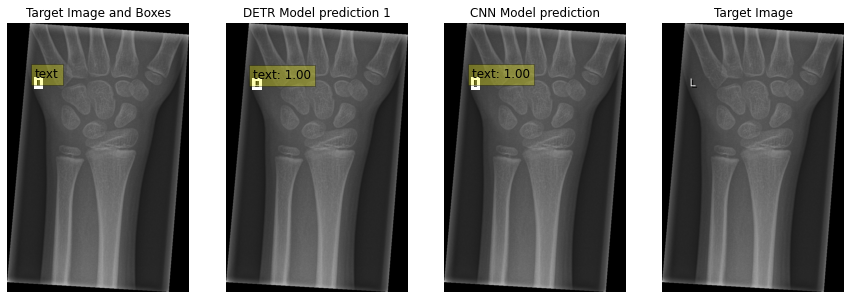

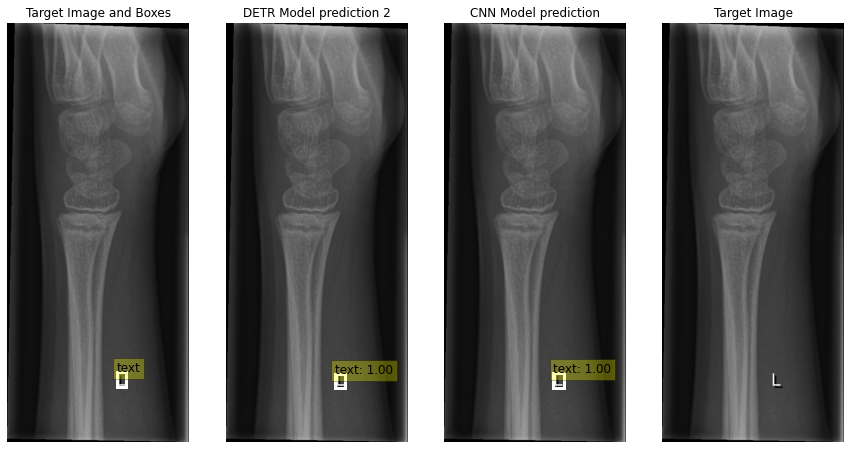

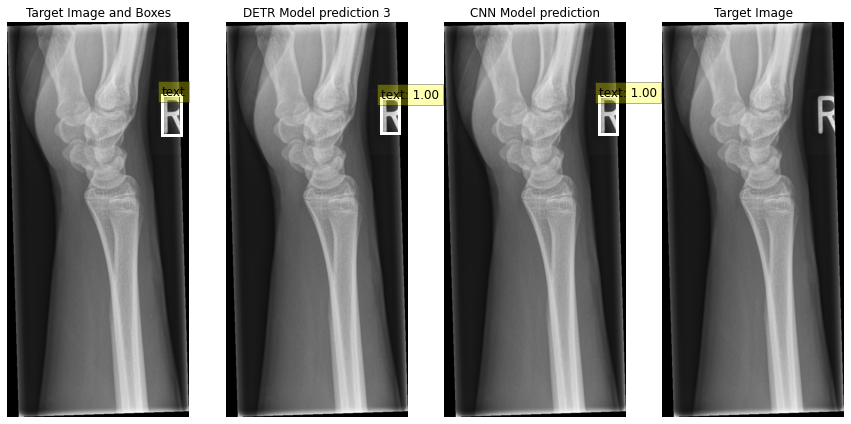

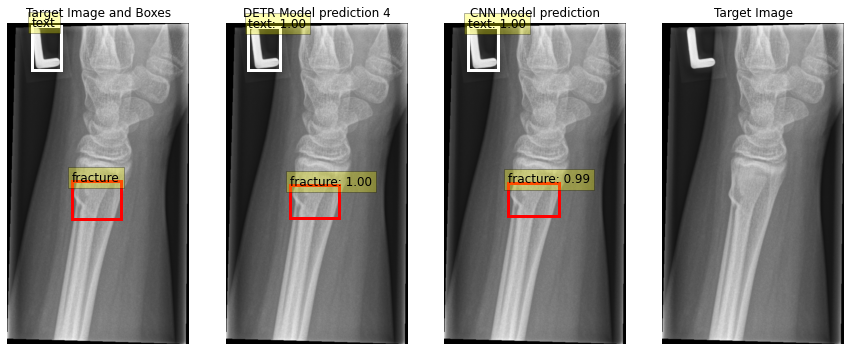

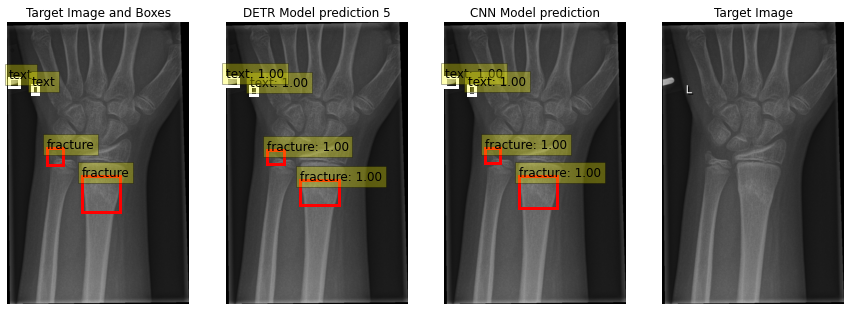

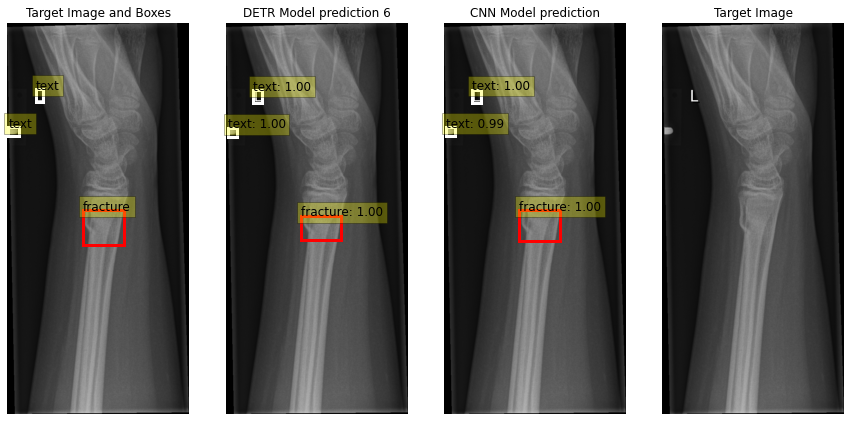

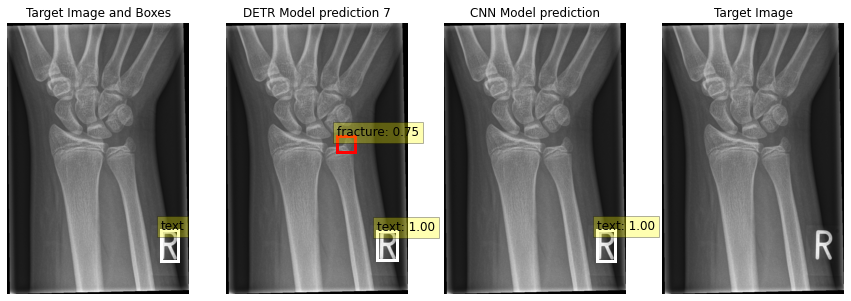

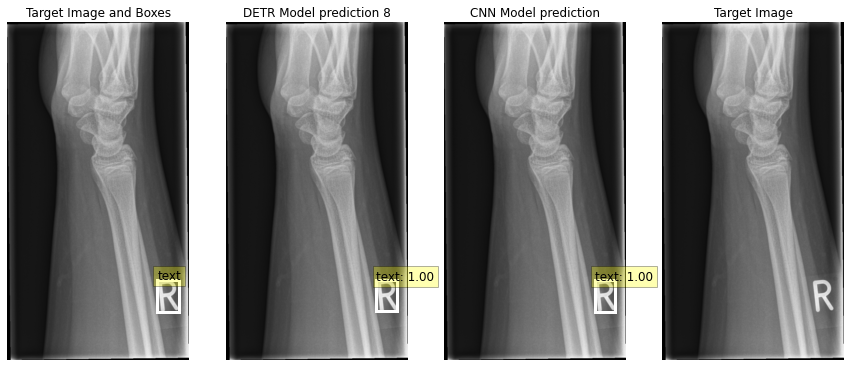

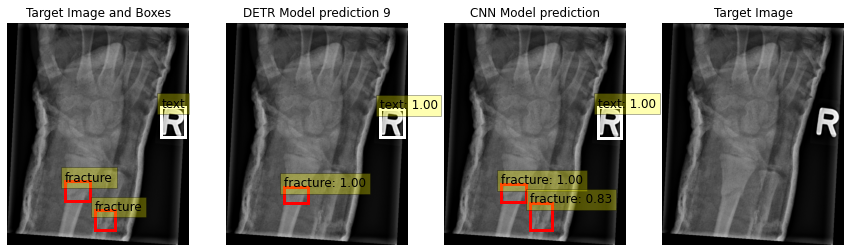

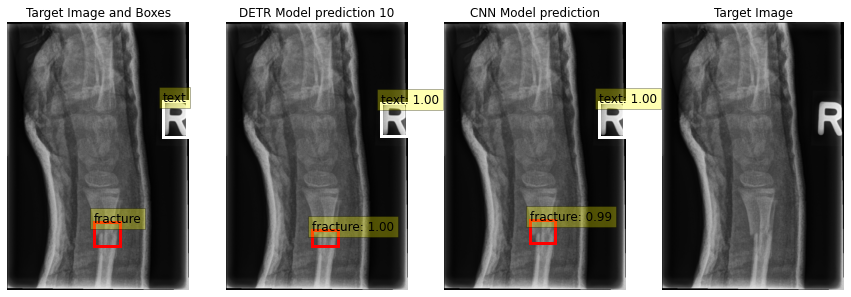

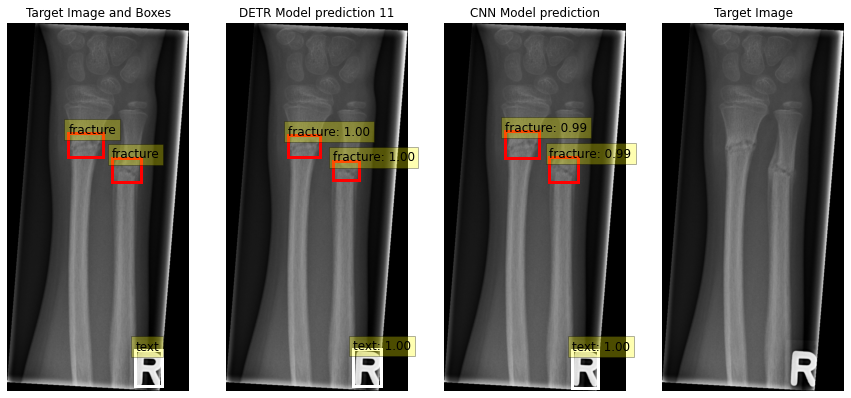

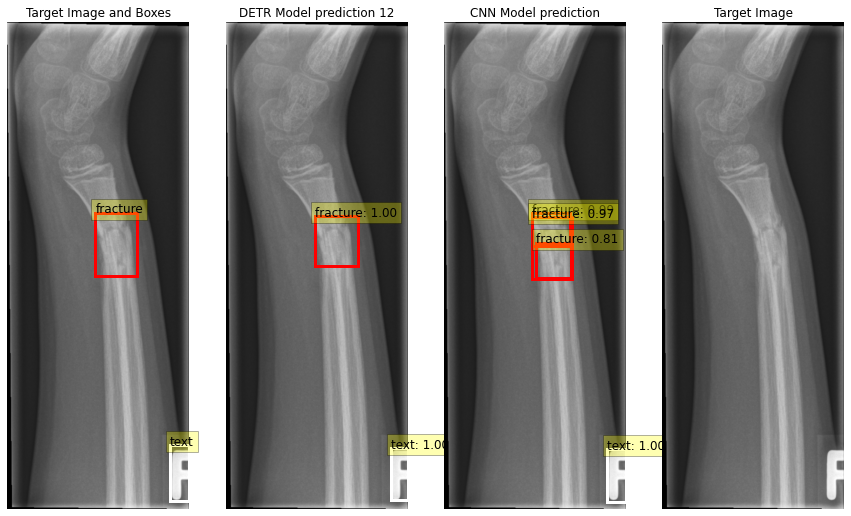

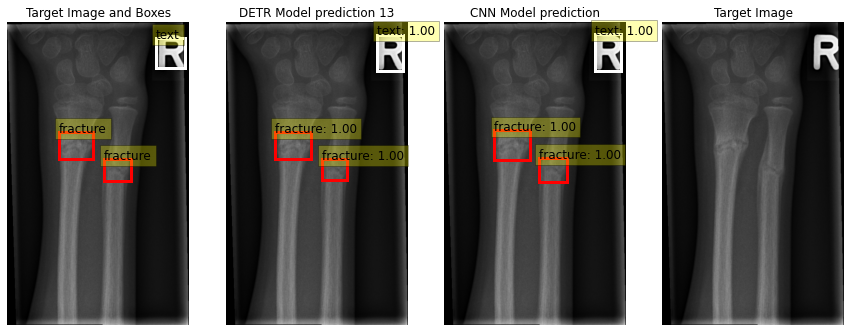

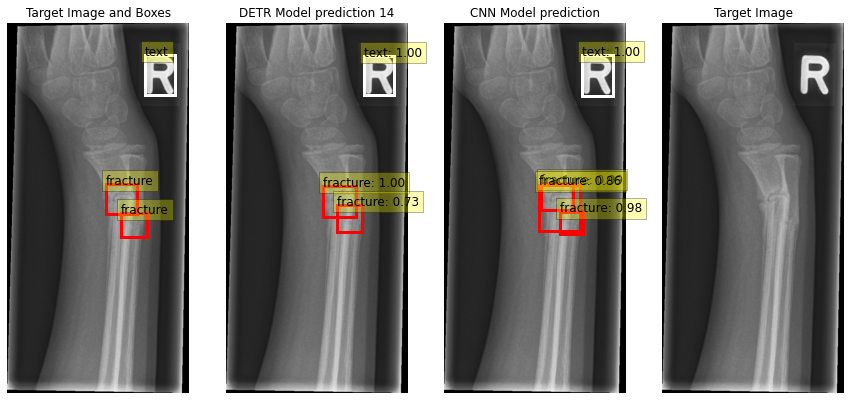

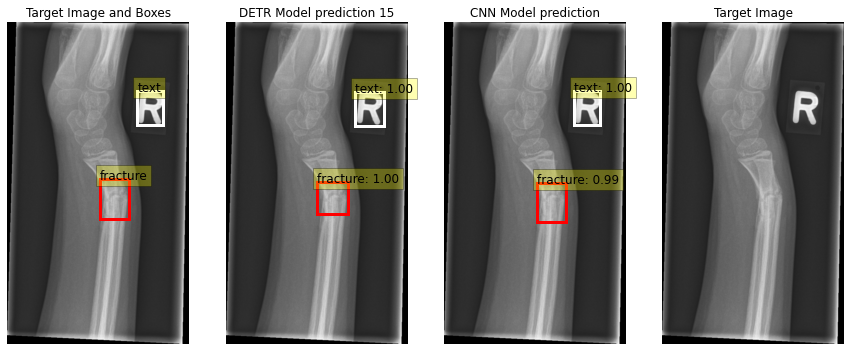

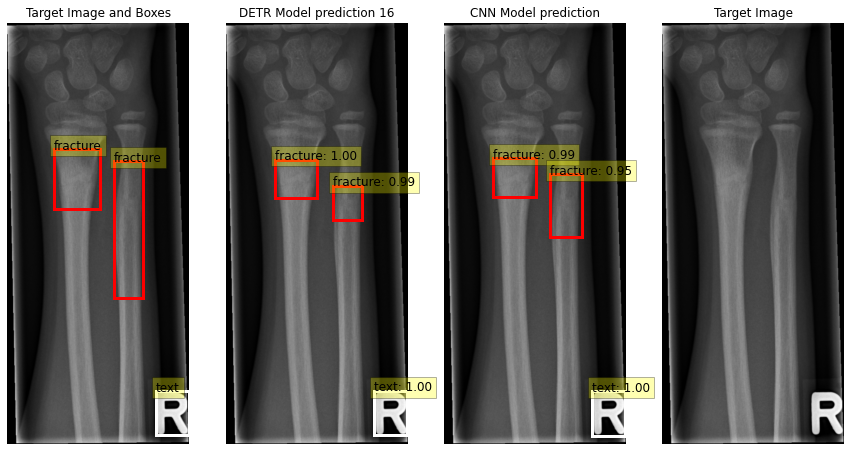

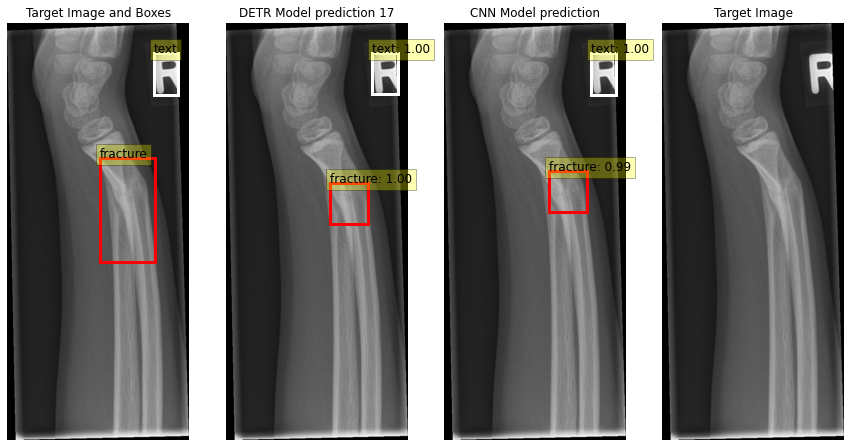

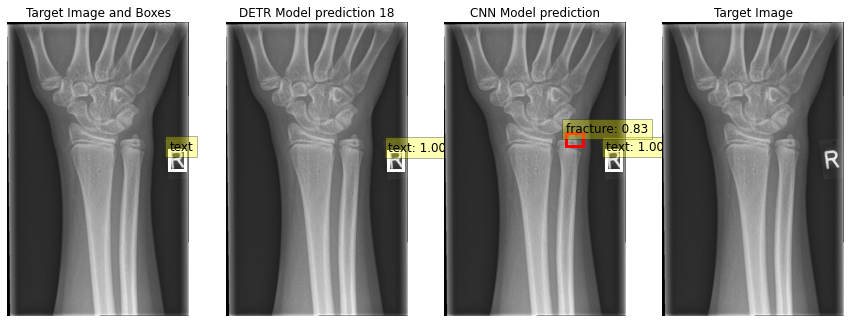

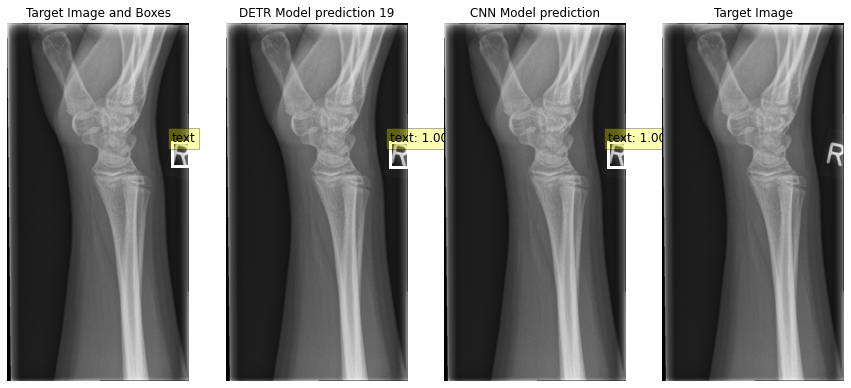

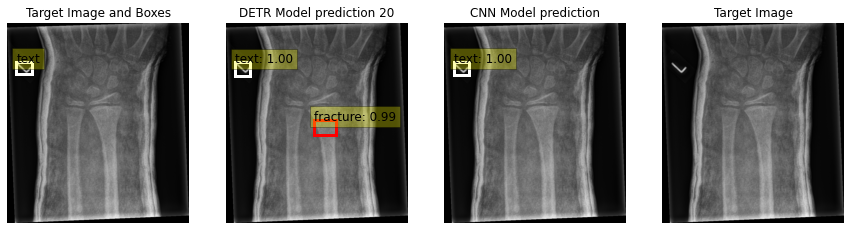

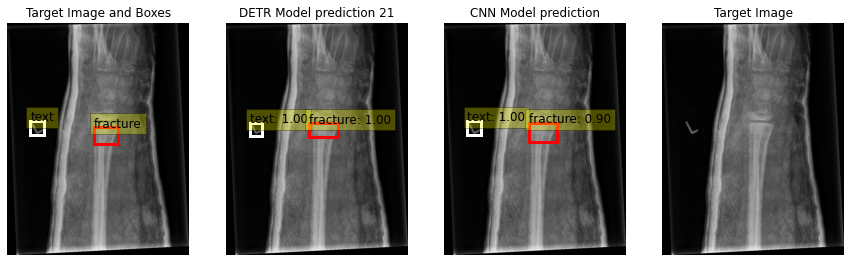

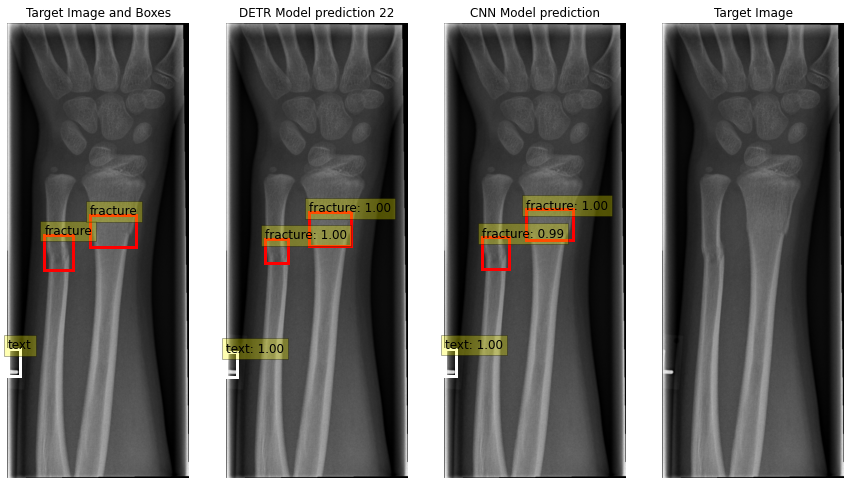

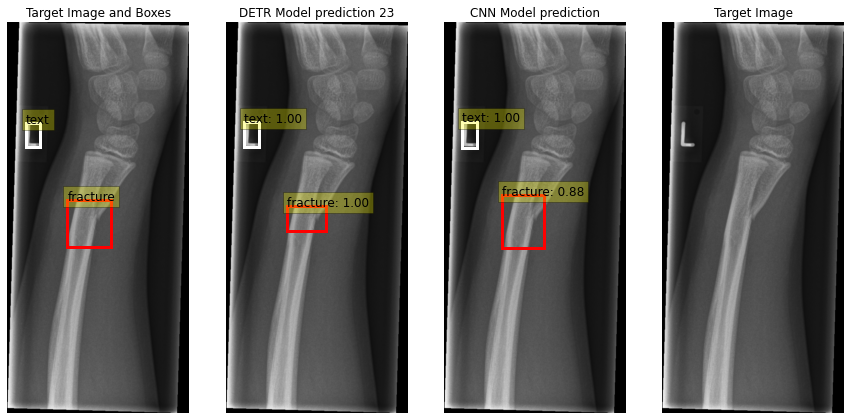

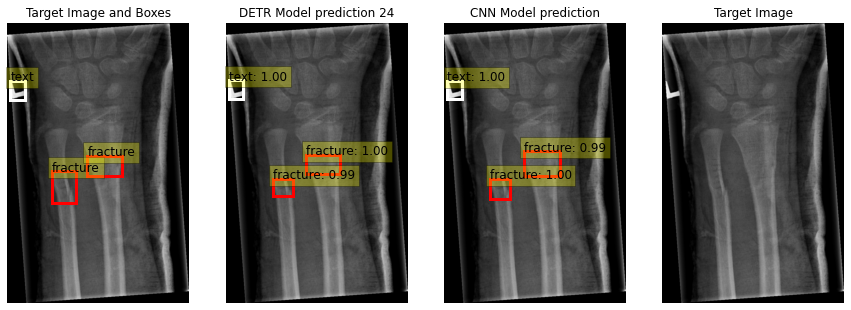

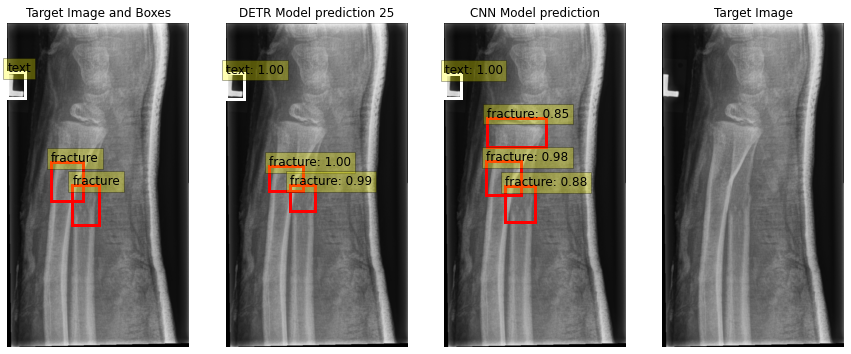

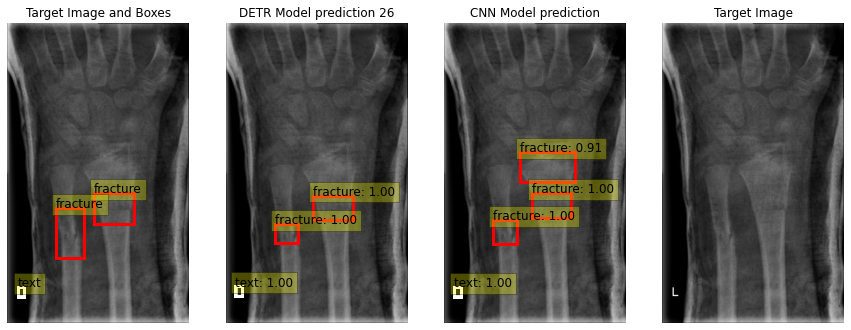

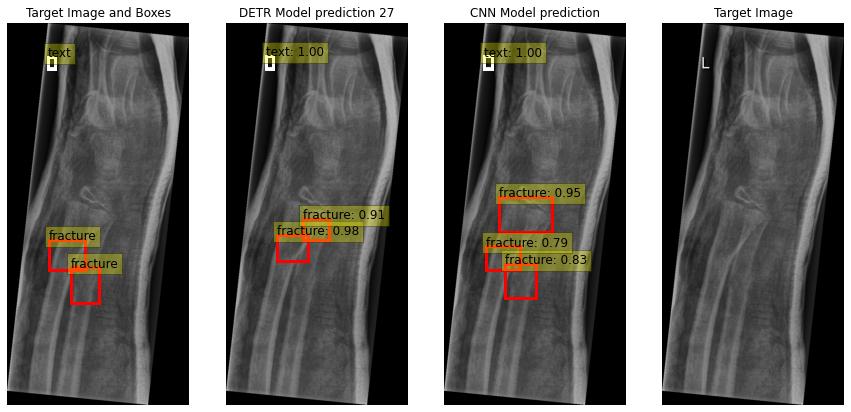

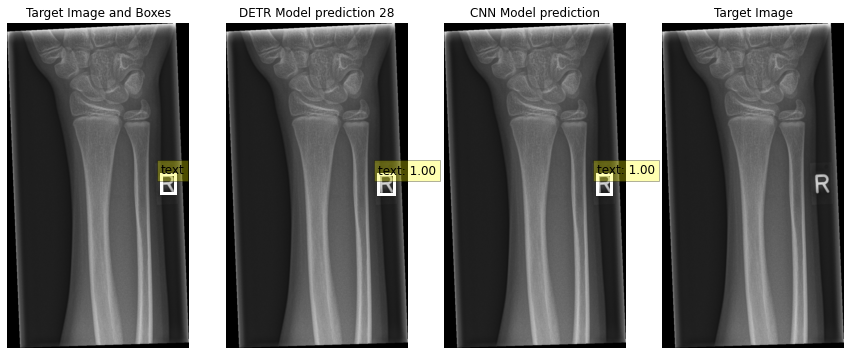

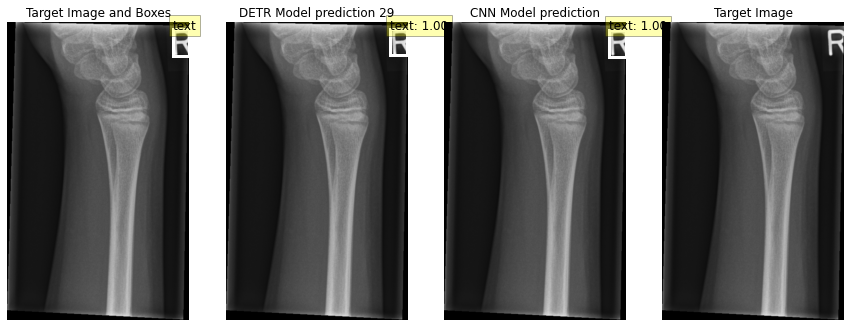

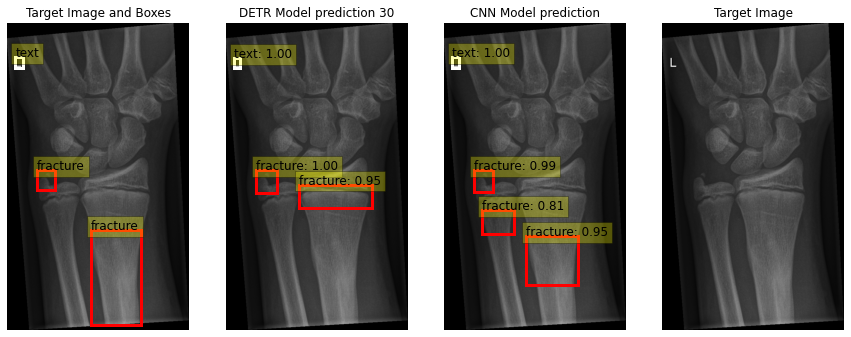

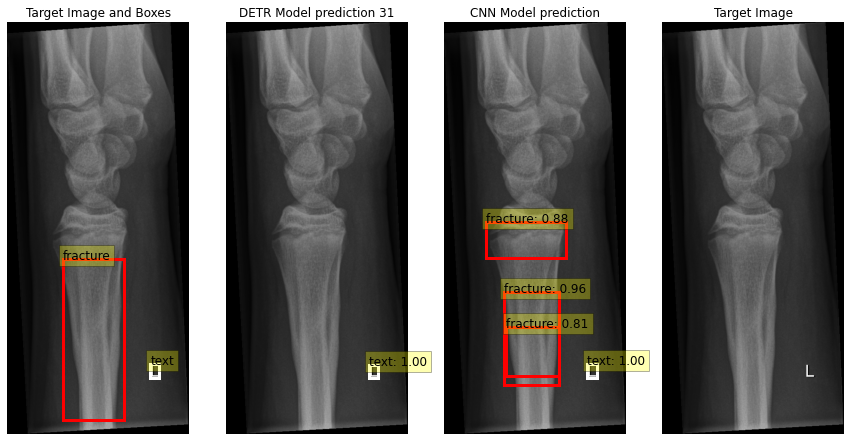

In [13]:
for cnn, detr in zip(results_cnn,results_detr):
    # Get the image and results for the current iteration
    img ,scores_cnn, labels_cnn, boxes_cnn = cnn

    pil_img , scores_detr , labels_detr , boxes_detr , annotations,image_id = detr
    
    
    # Call your plotting function for the current image and save the plot with the specified name
    plot_results(pil_img,img, scores_cnn, labels_cnn, boxes_cnn,scores_detr, labels_detr, boxes_detr,annotations,detr_model,image_id,confidence=0.7)

sort the detr data



In [23]:
import json

# Load the JSON file
with open('../data/test_coco_data.json', 'r') as f:
    data = json.load(f)

# Sort the images by file name
sorted_images = sorted(data['images'], key=lambda x: x['file_name'])

# Create a mapping between old and new image ids
id_map = {img['id']: i+1 for i, img in enumerate(sorted_images)}

# Update the image ids in the annotations
for ann in data['annotations']:
    ann['image_id'] = id_map[ann['image_id']]

# Update the image ids in the images
for img in sorted_images:
    img['id'] = id_map[img['id']]

# Replace the unsorted images with the sorted images
data['images'] = sorted_images

# Save the sorted JSON data to a file
with open('sorted_data.json', 'w') as f:
    json.dump(data, f, indent=4)
